## Assignment 8 - Loan Approval Prediction

### Data Preprocessing and feature engineering

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

# Load the data
df = pd.read_csv('Training Dataset.csv')

In [63]:
# Display basic information about the dataset
print(df.info())

# Display summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Display unique values in categorical columns
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].unique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None
       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         6

In [65]:
# Handle missing values
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median(), inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

# Encode categorical variables
le = LabelEncoder()
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Feature engineering
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['Income_to_Loan_Ratio'] = df['Total_Income'] / df['LoanAmount']

In [67]:
# Create a new feature: Total Income
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# Create a new feature: Income to Loan Amount Ratio
df['Income_Loan_Ratio'] = df['TotalIncome'] / df['LoanAmount']

# Create a new feature: Loan Amount to Term Ratio
df['Loan_Term_Ratio'] = df['LoanAmount'] / df['Loan_Amount_Term']

# Create a binary feature: Has Coapplicant
df['HasCoapplicant'] = (df['CoapplicantIncome'] > 0).astype(int)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


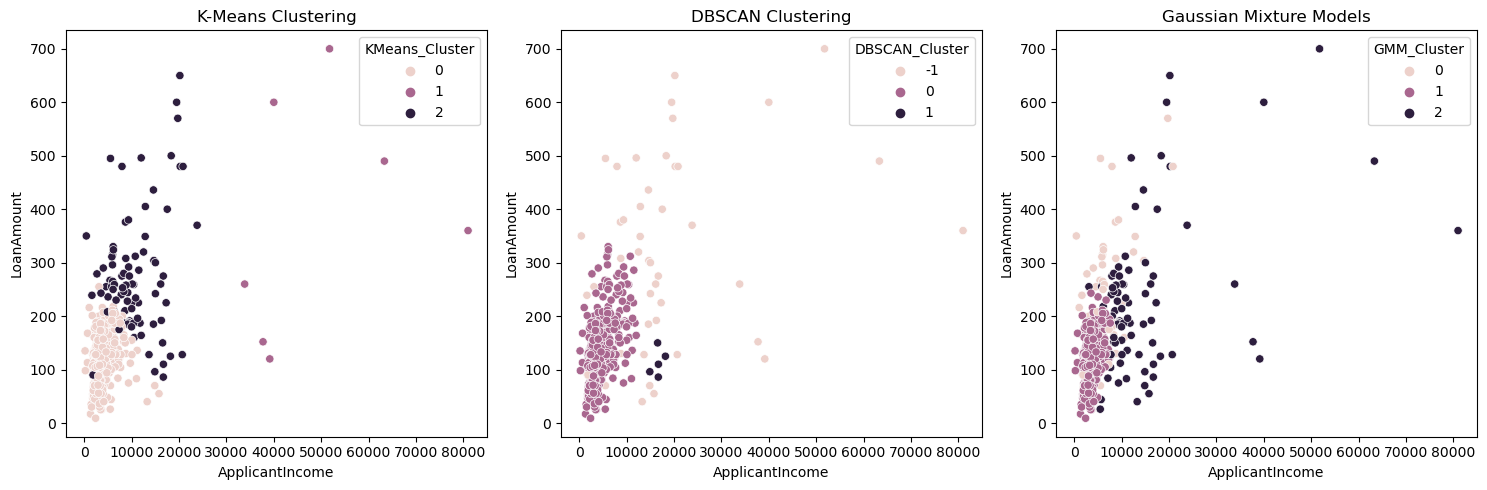

In [69]:
# Prepare data for clustering
X_cluster = df[['ApplicantIncome', 'LoanAmount', 'Total_Income']]
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(X_cluster_scaled)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_cluster_scaled)

# Gaussian Mixture Models
gmm = GaussianMixture(n_components=3, random_state=42)
df['GMM_Cluster'] = gmm.fit_predict(X_cluster_scaled)

# Visualize clusters
plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.scatterplot(x='ApplicantIncome', y='LoanAmount', hue='KMeans_Cluster', data=df)
plt.title('K-Means Clustering')
plt.subplot(132)
sns.scatterplot(x='ApplicantIncome', y='LoanAmount', hue='DBSCAN_Cluster', data=df)
plt.title('DBSCAN Clustering')
plt.subplot(133)
sns.scatterplot(x='ApplicantIncome', y='LoanAmount', hue='GMM_Cluster', data=df)
plt.title('Gaussian Mixture Models')
plt.tight_layout()
plt.show()

In [70]:
# Prepare features and target
X = df.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = df['Loan_Status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [71]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_pred))
print(classification_report(y_test, gb_pred))

Random Forest Accuracy: 0.7967479674796748
              precision    recall  f1-score   support

           0       0.82      0.53      0.65        43
           1       0.79      0.94      0.86        80

    accuracy                           0.80       123
   macro avg       0.81      0.74      0.75       123
weighted avg       0.80      0.80      0.78       123

Gradient Boosting Accuracy: 0.7967479674796748
              precision    recall  f1-score   support

           0       0.80      0.56      0.66        43
           1       0.80      0.93      0.86        80

    accuracy                           0.80       123
   macro avg       0.80      0.74      0.76       123
weighted avg       0.80      0.80      0.79       123



In [72]:
# L1 Regularization (Lasso)
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lasso_model.fit(X_train_scaled, y_train)
lasso_pred = lasso_model.predict(X_test_scaled)
print("L1 Regularization Accuracy:", accuracy_score(y_test, lasso_pred))
print(classification_report(y_test, lasso_pred))

# L2 Regularization (Ridge)
ridge_model = LogisticRegression(penalty='l2', random_state=42)
ridge_model.fit(X_train_scaled, y_train)
ridge_pred = ridge_model.predict(X_test_scaled)
print("L2 Regularization Accuracy:", accuracy_score(y_test, ridge_pred))
print(classification_report(y_test, ridge_pred))

# ElasticNet Regularization
elastic_model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42)
elastic_model.fit(X_train_scaled, y_train)
elastic_pred = elastic_model.predict(X_test_scaled)
print("ElasticNet Regularization Accuracy:", accuracy_score(y_test, elastic_pred))
print(classification_report(y_test, elastic_pred))

L1 Regularization Accuracy: 0.7886178861788617
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123

L2 Regularization Accuracy: 0.7886178861788617
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123

ElasticNet Regularization Accuracy: 0.7886178861788617
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                     

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [73]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'L1 Regularization': LogisticRegression(penalty='l1', solver='liblinear', random_state=42),
    'L2 Regularization': LogisticRegression(penalty='l2', random_state=42),
    'ElasticNet Regularization': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print(f"{name} Cross-Validation Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Random Forest Cross-Validation Accuracy: 0.7962 (+/- 0.0680)
Gradient Boosting Cross-Validation Accuracy: 0.7739 (+/- 0.0595)
L1 Regularization Cross-Validation Accuracy: 0.8105 (+/- 0.0536)
L2 Regularization Cross-Validation Accuracy: 0.8044 (+/- 0.0607)
ElasticNet Regularization Cross-Validation Accuracy: 0.8085 (+/- 0.0549)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [74]:
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train_scaled, y_train)
final_predictions = best_model.predict(X_test_scaled)
print("Final Model Accuracy:", accuracy_score(y_test, final_predictions))
print(classification_report(y_test, final_predictions))

Final Model Accuracy: 0.7967479674796748
              precision    recall  f1-score   support

           0       0.82      0.53      0.65        43
           1       0.79      0.94      0.86        80

    accuracy                           0.80       123
   macro avg       0.81      0.74      0.75       123
weighted avg       0.80      0.80      0.78       123

